# XMHW tests on the OFAM3 dataset

Purpose
-------
    The following will investigate the capability of xmhw to parallelise the MHW analysis on a subset of temperature data from the OFAM3 - 10th degree resolution global simulation from 1980-2100. The simulation runs from 1980 to 2006 under JRA55 atmospheric forcing, and thereafter the reanalysis is repeated but with the addition of the RCP8.5 climate trend.

    Contents:
        1. Load in Temperature Data and visualise (2D in space, 1D in time)
        2. Select the region around Australia to perform the heatwave analysis and throw rest away
        3. Calculate the climatology required for the heatwave analysis and save as a new netcdf file
            [ this will be read in later and in a new session for performing the heatwave analysis ]
        4. Perform heatwave analysis using xmhw by iterating around the subsetted grid

Thanks to John Reilly for sharing his [code](https://github.com/Thomas-Moore-Creative/shared_sandbox/blob/main/mhw-3d-scalingTests-gadiJup.ipynb)
    


### imports

In [1]:
import sys
import os

### data handling
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci

### plotting
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

### marine heatwaves python package
from xmhw.xmhw import threshold, detect

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)


wrkdir = "/g/data/fp2/OFAM3"
os.chdir(wrkdir)


python version = 3.10.
numpy version = 1.23.5
pandas version = 2.2.2
xarray version = 2024.3.0
scipy version = 1.12.0
matplotlib version = 3.8.4
cmocean version = v3.0.3
cartopy version = 0.23.0


### remove warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

### import the dask client for assessing performance

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36401,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:45927,Total threads: 1
Dashboard: /proxy/37599/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:42553,


## grab the future temperature data from fp2

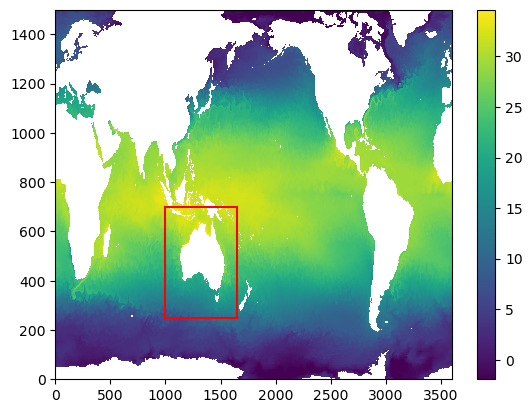

In [4]:
os.chdir(wrkdir)
sst = xr.open_mfdataset("./jra55_rcp8p5/surface/ocean_temp_sfc_205*.nc", combine='by_coords').squeeze()

x1 = 1000
x2 = 1650
y1 = 250
y2 = 700


plt.figure()
plt.pcolormesh(sst['temp'].isel(Time=0))
plt.plot((x1,x1),(y1,y2), 'r-')
plt.plot((x2,x2),(y1,y2), 'r-')
plt.plot((x1,x2),(y1,y1), 'r-')
plt.plot((x1,x2),(y2,y2), 'r-')
plt.colorbar()


## subset the data to be only around the australian continent

In [5]:
sst = sst.isel(yt_ocean=slice(y1,y2), xt_ocean=slice(x1,x2)).drop_vars('st_ocean')
sst = sst['temp'].rename({"Time":"time"}).compute()
sst


<xarray.DataArray 'temp' (time: 3652, yt_ocean: 450, xt_ocean: 650)> Size: 4GB
array([[[ 7.468338 ,  7.464981 ,  7.4599457, ..., 12.663349 ,
         12.5710335, 12.530746 ],
        [ 7.3978386,  7.337414 ,  7.297127 , ..., 12.804344 ,
         12.683491 , 12.597889 ],
        [ 7.302162 ,  7.2383804,  7.221596 , ..., 12.9470215,
         12.799309 , 12.680134 ],
        ...,
        [32.093876 , 32.281868 , 32.33726  , ..., 31.855526 ,
         31.853848 , 31.845455 ],
        [32.18284  , 32.36244  , 32.374187 , ..., 31.889095 ,
         31.877346 , 31.870632 ],
        [32.253334 , 32.417828 , 32.396008 , ..., 31.931059 ,
         31.912594 , 31.89413  ]],

       [[ 7.4112663,  7.439804 ,  7.461624 , ..., 12.725456 ,
         12.62978  , 12.5962105],
        [ 7.406231 ,  7.3911247,  7.355877 , ..., 12.866451 ,
         12.735527 , 12.658314 ],
        [ 7.349163 ,  7.29377  ,  7.248451 , ..., 13.004089 ,
         12.84631  , 12.733849 ],
...
        [31.479538 , 31.479538 , 31.481216 , ..., 32.627644 ,
         32.627644 , 32.627644 ],
        [31.513107 , 31.50975  , 31.50975  , ..., 32.625965 ,
         32.627644 , 32.629322 ],
        [31.546679 , 31.54332  , 31.539963 , ..., 32.624287 ,
         32.625965 , 32.627644 ]],

       [[ 7.525406 ,  7.503586 ,  7.4985504, ..., 11.829128 ,
         12.008728 , 12.1010475],
        [ 7.6429024,  7.616047 ,  7.5791206, ..., 11.874447 ,
         12.064121 , 12.161472 ],
        [ 7.738579 ,  7.713402 ,  7.6764717, ..., 11.939911 ,
         12.121189 , 12.213509 ],
        ...,
        [31.435896 , 31.437574 , 31.437574 , ..., 32.60079  ,
         32.594074 , 32.590717 ],
        [31.472824 , 31.472824 , 31.469467 , ..., 32.595753 ,
         32.592396 , 32.58904  ],
        [31.514786 , 31.511429 , 31.506393 , ..., 32.590717 ,
         32.58904  , 32.58904  ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 29kB 2050-01-01T12:00:00 ... 2059-12-31T1...
  * xt_ocean  (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.8 164.9 164.9
  * yt_ocean  (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.25 -5.15 -5.05
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [6]:
print("Future SST dataset = %i Gb"%(sst.nbytes/1e9))

Future SST dataset = 4 Gb


## fetch the climatology and threshold that were calculated in the other notebook

In [7]:
os.chdir("/g/data/es60/pjb581/heatwaves")
climatology = xr.open_dataset('Australian_SST_daily_climatology.nc')['temp']
threshold90 = xr.open_dataset('Australian_SST_daily_MHWthreshold.nc')['temp']

threshold90


<xarray.DataArray 'temp' (doy: 366, yt_ocean: 450, xt_ocean: 650)> Size: 856MB
[107055000 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.8 164.9 164.9
  * yt_ocean  (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.25 -5.15 -5.05
  * doy       (doy) int64 3kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

## detect MHWs

In [8]:
sst1 = sst.copy(deep=True).chunk({'time':-1, 'yt_ocean':50, 'xt_ocean':50})

print("Adding 'year' as a new coordinate") 
sst1['year'] = sst1['time'].dt.year

print("Adjust for proper day indexing in leap years")
def adjust_dayofyear(times):
    return np.array([pd.Timestamp(t).dayofyear for t in times])

print("Adding 'doy' as a new coordinate")
print(" This is essential because we need to be able to compare the threshold with dimensions ('doy', 'lat', 'lon') to the new SST dataset")
print(" i.e., at each day of the year, we see if the SST is greater than the threshold")
sst1['doy'] = (('time',), adjust_dayofyear(sst1['time'].values))

sst1 = sst1.set_index(time=['year', 'doy'])
sst1


Adding 'year' as a new coordinate
Adjust for proper day indexing in leap years
Adding 'doy' as a new coordinate
 This is essential because we need to be able to compare the threshold with dimensions ('doy', 'lat', 'lon') to the new SST dataset
 i.e., at each day of the year, we see if the SST is greater than the threshold


<xarray.DataArray 'temp' (time: 3652, yt_ocean: 450, xt_ocean: 650)> Size: 4GB
dask.array<xarray-<this-array>, shape=(3652, 450, 650), dtype=float32, chunksize=(3652, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.8 164.9 164.9
  * yt_ocean  (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.25 -5.15 -5.05
  * time      (time) object 29kB MultiIndex
  * year      (time) int64 29kB 2050 2050 2050 2050 2050 ... 2059 2059 2059 2059
  * doy       (time) int64 29kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [9]:
print("Detect MHWs")

mhws = {}
diff = {}

for yr in np.unique(sst1['year'].values):
    print(yr)
    tmp = sst1.sel(year=yr)
    if (yr == 2052) or (yr == 2056):
        print("leap")
        mhws['%i'%(yr)] = tmp > threshold90
        diff['%i'%(yr)] = tmp - threshold90
    else:
        mhws['%i'%(yr)] = tmp > threshold90
        diff['%i'%(yr)] = tmp - threshold90
    mhws['%i'%(yr)] = mhws['%i'%(yr)].rename({"doy":"time"}).assign_coords(time = pd.date_range(start=f"{yr}-01-01", end=f"{yr}-12-31", freq='D'))
    diff['%i'%(yr)] = diff['%i'%(yr)].rename({"doy":"time"}).assign_coords(time = pd.date_range(start=f"{yr}-01-01", end=f"{yr}-12-31", freq='D'))

print("Concatenate the years")
tmp = list(mhws.values())
mhws = xr.concat(tmp, dim='time')

tmp = list(diff.values())
diff = xr.concat(tmp, dim='time')

del tmp

Detect MHWs
2050
2051
2052
leap
2053
2054
2055
2056
leap
2057
2058
2059
Concatenate the years


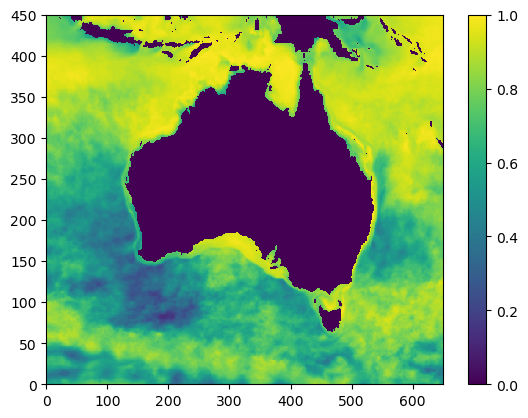

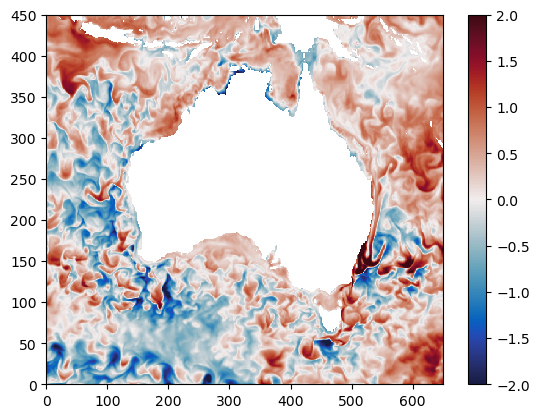

In [10]:
plt.figure()
plt.pcolormesh(mhws.mean(dim='time'))
plt.colorbar()

plt.figure()
plt.pcolormesh(diff.isel(time=365), cmap = cmo.balance, vmin=-2, vmax=2)
plt.colorbar()



## Now apply a rolling mean on the data in time to determine where MHWs occur
    If the sum over a window of x days is at least x, it indicates that the SST was above the threshold for x consecutive days.

CPU times: user 1min 29s, sys: 33.2 s, total: 2min 2s
Wall time: 2min 3s


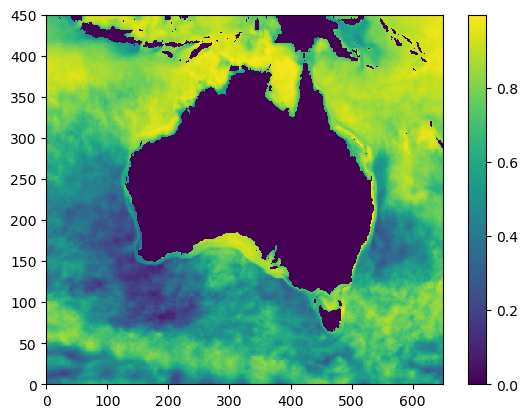

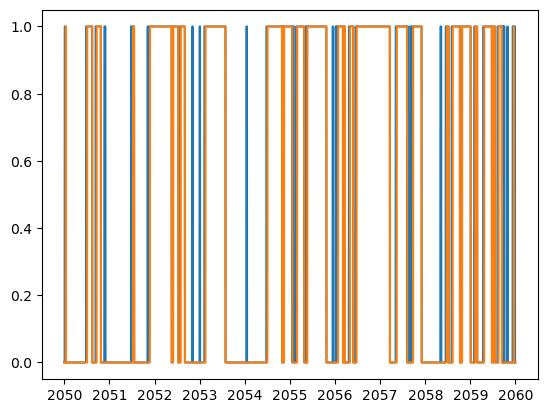

In [11]:
%%time

### set minimum duration of a heatwave
min_duration = 10
mhws_occurance = mhws.rolling(time=min_duration, center=False).sum() >= min_duration

plt.figure()
plt.pcolormesh(mhws_occurance.mean(dim='time'))
plt.colorbar()

plt.figure()
plt.plot(mhws.coords['time'], mhws.isel(xt_ocean=100,yt_ocean=100))
plt.plot(mhws_occurance.coords['time'], mhws_occurance.isel(xt_ocean=100,yt_ocean=100))



## create an event label data array
    all events at each point in space are numbered from 1 onwards

In [12]:
%%time
# Label continuous events in time
def label_events(da):
    shifted = da.shift(time=1, fill_value=False)
    new_event_start = da & ~shifted
    event_labels = new_event_start.cumsum(dim='time')
    return event_labels.where(da)

event_labels = label_events(mhws_occurance).compute()


CPU times: user 2min 9s, sys: 1min 1s, total: 3min 11s
Wall time: 3min 13s


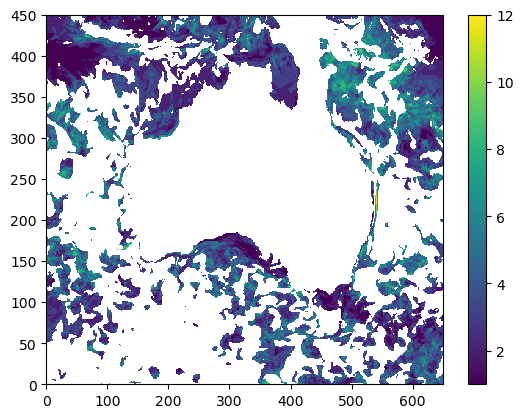

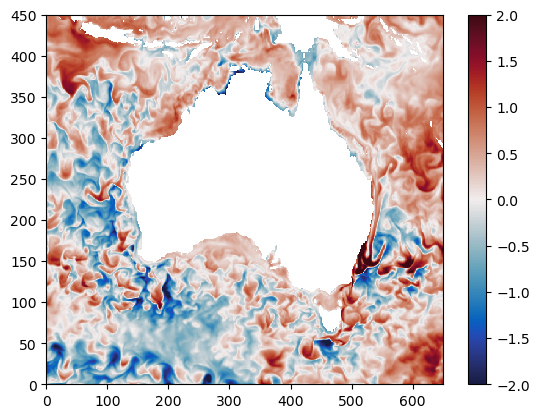

In [14]:
plt.figure()
plt.pcolormesh(event_labels.isel(time=365))
plt.colorbar()

plt.figure()
plt.pcolormesh(diff.isel(time=365), cmap = cmo.balance, vmin=-2, vmax=2)
plt.colorbar()


In [15]:
%%time

# Find maximum number of events in the dataset
max_event_number = int(event_labels.max().values)
print("Max number of events over the grid =", max_event_number)

# Create a new Dataset with the event dimension set to 71
mhws_ds = xr.Dataset({
    'duration': xr.DataArray(
        np.nan, 
        dims=('event', 'yt_ocean', 'xt_ocean'),
        coords={
            'event': np.arange(1, max_event_number+1),  # Using 1-based indexing for events
            'yt_ocean': event_labels.coords['yt_ocean'].values,
            'xt_ocean': event_labels.coords['xt_ocean'].values
        }
    ),
    'intensity_mean': xr.DataArray(
        np.nan, 
        dims=('event', 'yt_ocean', 'xt_ocean'),
        coords={
            'event': np.arange(1, max_event_number+1),  # Using 1-based indexing for events
            'yt_ocean': event_labels.coords['yt_ocean'].values,
            'xt_ocean': event_labels.coords['xt_ocean'].values
        }
    ),
    'intensity_max': xr.DataArray(
        np.nan, 
        dims=('event', 'yt_ocean', 'xt_ocean'),
        coords={
            'event': np.arange(1, max_event_number+1),  # Using 1-based indexing for events
            'yt_ocean': event_labels.coords['yt_ocean'].values,
            'xt_ocean': event_labels.coords['xt_ocean'].values
        }
    )
})
mhws_ds


Max number of events over the grid = 71
CPU times: user 1.44 s, sys: 185 ms, total: 1.62 s
Wall time: 1.18 s


<xarray.Dataset> Size: 498MB
Dimensions:         (event: 71, yt_ocean: 450, xt_ocean: 650)
Coordinates:
  * event           (event) int64 568B 1 2 3 4 5 6 7 8 ... 65 66 67 68 69 70 71
  * yt_ocean        (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.15 -5.05
  * xt_ocean        (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.9 164.9
Data variables:
    duration        (event, yt_ocean, xt_ocean) float64 166MB nan nan ... nan
    intensity_mean  (event, yt_ocean, xt_ocean) float64 166MB nan nan ... nan
    intensity_max   (event, yt_ocean, xt_ocean) float64 166MB nan nan ... nan

### calculate the duration of the MHWs

In [16]:
%%time

for event_id in range(1, max_event_number+1):
    if event_id%5 == 0:
        print(event_id)
    event_mask = event_labels == event_id
    event_duration = event_mask.sum(dim='time')  # Counts the days per event
    
    # Place the calculated duration into the correct position in the new dataset
    mhws_ds['duration'].loc[{'event': event_id}] = event_duration



10
20
30
40
50
60
70
CPU times: user 2min 57s, sys: 29 s, total: 3min 26s
Wall time: 2min 33s


In [ ]:
diff = diff.compute()


### Calculate the mean intensity of the MHWs

In [17]:
%%time

for event_id in range(1, max_event_number+1):
    if event_id%5 == 0:
        print(event_id)
    event_meanintensity = diff.where(event_labels == event_id).mean(dim='time')
    
    # Place the calculated mean intensity into the correct position in the new dataset
    mhws_ds['intensity_mean'].loc[{'event': event_id}] = event_meanintensity


10
20
30
40
50
60
70
CPU times: user 16min 17s, sys: 7min 43s, total: 24min 1s
Wall time: 17min 41s


### Calculate the maximum intensity of the MHWs

In [20]:
%%time

for event_id in range(1, max_event_number+1):
    if event_id%5 == 0:
        print(event_id)
    event_maxintensity = diff.where(event_labels == event_id).max(dim='time')
    
    # Place the calculated max intensity into the correct position in the new dataset
    mhws_ds['intensity_max'].loc[{'event': event_id}] = event_maxintensity


5
10
15
20
25
30
35
40
45
50
55
60
65
70
CPU times: user 12min 28s, sys: 3min 17s, total: 15min 45s
Wall time: 11min 43s


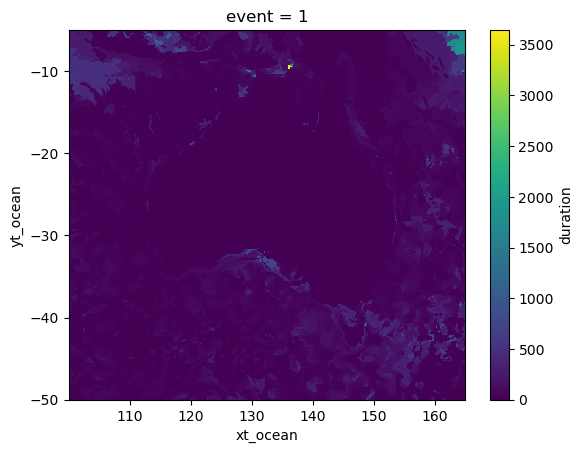

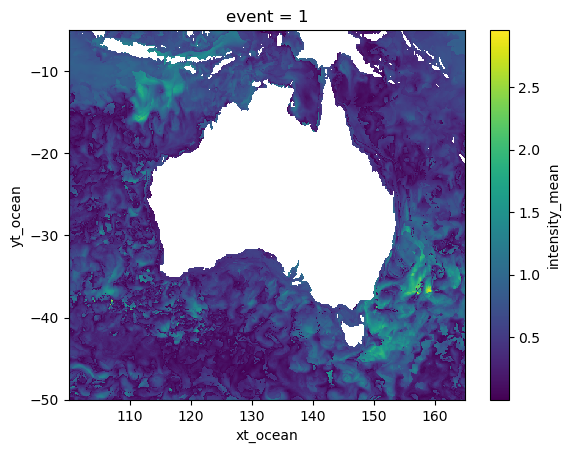

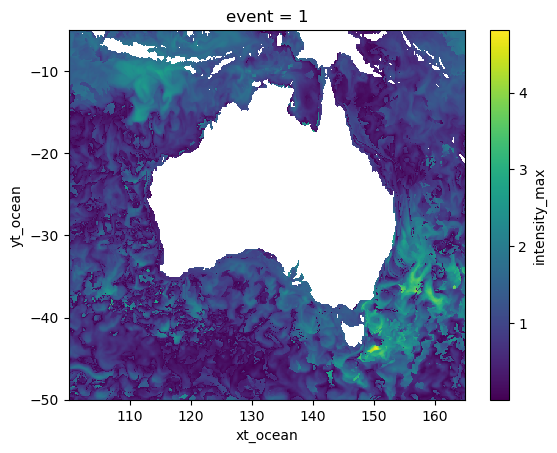

In [21]:
plt.figure()
mhws_ds['duration'].isel(event=0).plot()
plt.figure()
mhws_ds['intensity_mean'].isel(event=0).plot()
plt.figure()
mhws_ds['intensity_max'].isel(event=0).plot()


## save to disk

In [22]:
%%time
os.chdir("/g/data/es60/pjb581/heatwaves")
os.getcwd()

print("Saving mhws_ds to disk")
mhws_ds.to_netcdf('Australian_MHWs_2050s.nc', mode='w')


Saving mhws_ds to disk
CPU times: user 174 ms, sys: 760 ms, total: 934 ms
Wall time: 1.12 s
